<a href="https://colab.research.google.com/github/MILIND-SEN/GTA-Project/blob/main/GROUP26_GTA_PROJECT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This Notebook presents study and implementation  of Graph Networks in Three parts.


1.   Part-I : General representation and visualisation of graphs and traditional methods using graph laplacian
2.   Part-II: Deep learning with graphs-Implementation of Graph neural Network on CORA dataset
3.   Part-III: Implementation of Paper- Text Classification using Graph Convolution Networks

References:

*   https://analyticsindiamag.com/building-and-modelling-a-graph-neural-network-from-scratch/?utm_medium=onesignal&utm_source=onesignal
*   https://theaisummer.com/graph-convolutional-networks/
*   https://antonsruberts.github.io/graph/gcn/
*   Implemented Paper : https://arxiv.org/abs/1809.05679- Graph Convolutional Networks for Text Classification


**Part-I: General representation and visualisation of graphs G=(V,E)**

In [ ]:
from google.colab import drive
drive.mount('/content/MyDrive', force_remount=True) 

Mounted at /content/MyDrive


In [ ]:
def create_graph_lapl(a):
 return calc_degree_matrix(a)-a
print(a)
print(create_graph_lapl(a))

tensor([[1., 1., 0., 0., 1.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 1.],
        [0., 0., 1., 1., 0.]])
tensor([[ 2., -1.,  0.,  0., -1.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0., -1.,  1.,  0.,  0.],
        [ 0., -1.,  0.,  2., -1.],
        [ 0.,  0., -1., -1.,  2.]])


In [ ]:
def calc_degree_matrix_norm(a):
 return torch.diag(torch.pow(a.sum(dim=-1),-0.5))

#Normalisation is necessary for the adjacency matrix
def create_graph_lapl_norm(a):
 size = a.shape[-1]
 D_norm = calc_degree_matrix_norm(a)
 L_norm = torch.ones(size) - (D_norm @ a @ D_norm )
 return L_norm
a_norm = create_graph_lapl_norm(a)
print(a)
print(a_norm)

tensor([[1., 1., 0., 0., 1.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 1.],
        [0., 0., 1., 1., 0.]])
tensor([[0.6667, 0.4226, 1.0000, 1.0000, 0.5918],
        [1.0000, 0.0000, 1.0000, 1.0000, 1.0000],
        [1.0000, 0.0000, 1.0000, 1.0000, 1.0000],
        [1.0000, 0.2929, 1.0000, 1.0000, 0.5000],
        [1.0000, 1.0000, 0.2929, 0.5000, 1.0000]])


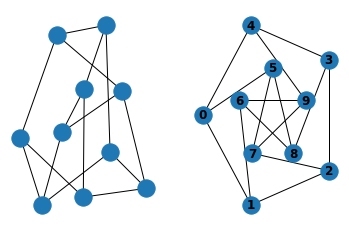

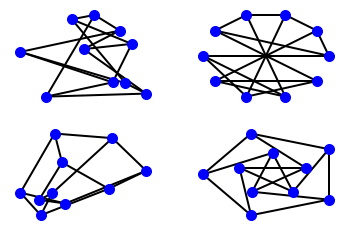

In [ ]:
#Visualising the graph networks
import matplotlib.pyplot as plt
import networkx as nx
G = nx.petersen_graph()
plt.subplot(121)
nx.draw(G, with_labels=False, font_weight='bold')
plt.subplot(122)
nx.draw_shell(G, nlist=[range(5, 10), range(5)], with_labels=True, font_weight='bold')

plt.figure()
options = {
    'node_color': 'blue',
    'node_size': 100,
    'width': 2,
}
plt.subplot(221)
nx.draw_random(G, **options)
plt.subplot(222)
nx.draw_circular(G, **options)
plt.subplot(223)
nx.draw_spectral(G, **options)
plt.subplot(224)
nx.draw_shell(G, nlist=[range(5,10), range(5)], **options)

**Spectral Image segmentation with Graph Laplacian**

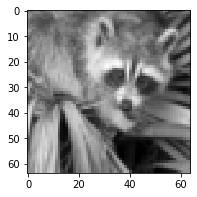

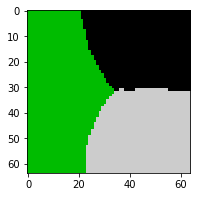

In [ ]:
import numpy as np
from scipy import misc
from skimage.transform import resize
import matplotlib.pyplot as plt
from numpy import linalg as LA
from scipy.sparse import csgraph
from sklearn.feature_extraction.image import img_to_graph
from sklearn.cluster import spectral_clustering

#misc.face gives a racoon image, first downsample.
re_size = 64 
img = misc.face(gray=True)  
img = resize(img, (re_size, re_size))
mask = img.astype(bool)
graph = img_to_graph(img, mask=mask)
# Take a decreasing function of the gradient: we take it weakly
# dependant from the gradient the segmentation is close to a voronoi
graph.data = np.exp(-graph.data / graph.data.std())
labels = spectral_clustering(graph, n_clusters=3)
label_im = -np.ones(mask.shape)
label_im[mask] = labels

plt.figure(figsize=(6, 3))
plt.imshow(img, cmap='gray', interpolation='nearest')

plt.figure(figsize=(6, 3))
plt.imshow(label_im, cmap=plt.cm.nipy_spectral, interpolation='nearest')
plt.show()

**Part-II: Deep Learning : Graph Neural Networks**

Dataset: CORA

 The dataset consists of 2708 nodes which correspond to scientific publications.

*   Nodes are classified into 7 categories

*   Edges indicate whether a document is cited by the other document or vice versa

*   Each node has 1433 features which is denoted by 0/1 valued vector indicating the BOW from the dictionary






In [ ]:
data_dir = "/content/MyDrive/MyDrive/GTA-1/Proj1/gcn/cora_data"

import pandas as pd
import os
citations_data = pd.read_csv(
    os.path.join(data_dir, "cora.cites"),
    sep="\t",
    header=None,
    names=["target", "source"],
)

In [ ]:
citations_data.head()

,target,source
0,35,1033
1,35,103482
2,35,103515
3,35,1050679
4,35,1103960


In [ ]:
column_names = ["paper_id"] + [f"term_{idx}" for idx in range(1433)] + ["subject"]
papers_data = pd.read_csv(
    os.path.join(data_dir, "cora.content"), sep="\t", header=None, names=column_names,
)
print("Papers shape:", papers_data.shape)

Papers shape: (2708, 1435)


In [ ]:
print("Papers shape:", papers_data.shape)
papers_data.head()

Papers shape: (2708, 1435)


,paper_id,term_0,term_1,term_2,term_3,term_4,term_5,term_6,term_7,term_8,...,term_1424,term_1425,term_1426,term_1427,term_1428,term_1429,term_1430,term_1431,term_1432,subject
0,31336,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,Neural_Networks
1,1061127,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,Rule_Learning
2,1106406,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Reinforcement_Learning
3,13195,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Reinforcement_Learning
4,37879,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Probabilistic_Methods


In [ ]:
class_values = sorted(papers_data["subject"].unique())
class_idc = {name: id for id, name in enumerate(class_values)}
paper_idc = {name: idx for idx, name in enumerate(sorted(papers_data["paper_id"].unique()))}

papers_data["paper_id"] = papers_data["paper_id"].apply(lambda name: paper_idc[name])
citations_data["source"] = citations_data["source"].apply(lambda name: paper_idc[name])
citations_data["target"] = citations_data["target"].apply(lambda name: paper_idc[name])
papers_data["subject"] = papers_data["subject"].apply(lambda value: class_idc[value])

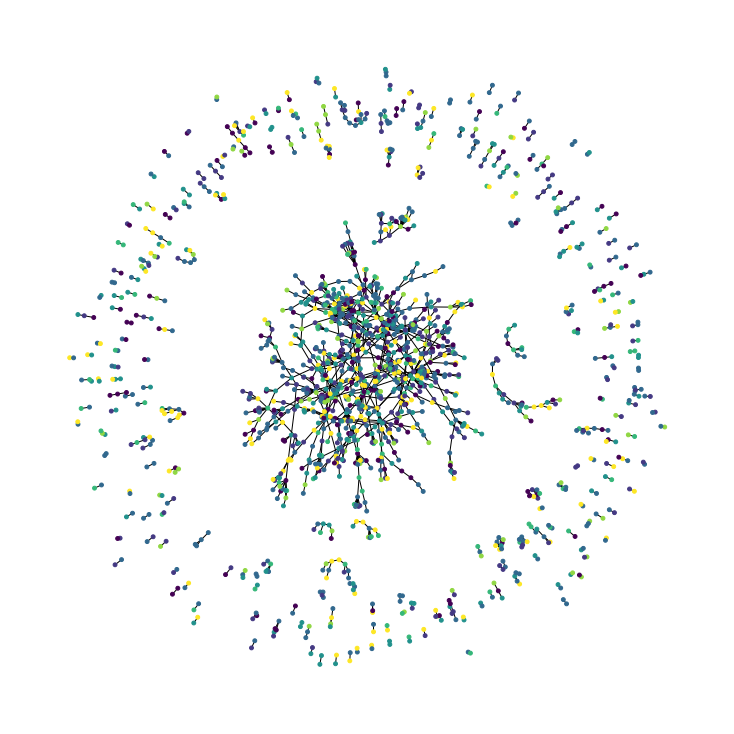

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
colors = papers_data["subject"].tolist()
cora_graph = nx.from_pandas_edgelist(citations_data.sample(n=1500))
subjects = list(papers_data[papers_data["paper_id"].isin(list(cora_graph.nodes))]["subject"])
nx.draw_spring(cora_graph, node_size=15, node_color=subjects)


In [ ]:
import numpy as np
train, test = [], []

for _, group in papers_data.groupby("subject"):
    # Select around 50% of the dataset for training.
    random_selection = np.random.rand(len(group.index)) <= 0.5
    train.append(group[random_selection])
    test.append(group[~random_selection])

train = pd.concat(train).sample(frac=1)
test = pd.concat(test).sample(frac=1)

print("Train data shape:", train.shape)
print("Test data shape:", test.shape)

Train data shape: (1356, 1435)
Test data shape: (1352, 1435)


In [ ]:
import tensorflow as tf
feature_names = set(papers_data.columns) - {"paper_id", "subject"}
# Create an edges array (sparse adjacency matrix) of shape [2, num_edges].
edges = citations_data[["source", "target"]].to_numpy().T
# Create an edge weights array of ones.
edge_weights = tf.ones(shape=edges.shape[1])
# Create a node features array of shape [num_nodes, num_features].
node_features = tf.cast(
    papers_data.sort_values("paper_id")[feature_names].to_numpy(), dtype=tf.dtypes.float32
)
# Create graph info tuple with node_features, edges, and edge_weights.
graph_info = (node_features, edges, edge_weights)

print("Edges shape:", edges.shape)
print("Nodes shape:", node_features.shape)

Edges shape: (2, 5429)
Nodes shape: (2708, 1433)


In [ ]:
print("Edges_weights shape:", edge_weights.shape)

Edges_weights shape: (5429,)


In [ ]:
from tensorflow.keras import layers
class GraphConvLayer(layers.Layer):
    def __init__(
        self,
        hidden_units,
        dropout_rate=0.2,
        aggregation_type="mean",
        combination_type="concat",
        normalize=False,
        *args,
        **kwargs,
    ):
        super(GraphConvLayer, self).__init__(*args, **kwargs)

        self.aggregation_type = aggregation_type
        self.combination_type = combination_type
        self.normalize = normalize

        self.ffn_prepare = create_ffn(hidden_units, dropout_rate)
        if self.combination_type == "gated":
            self.update_fn = layers.GRU(
                units=hidden_units,
                activation="tanh",
                recurrent_activation="sigmoid",
                dropout=dropout_rate,
                return_state=True,
                recurrent_dropout=dropout_rate,
            )
        else:
            self.update_fn = create_ffn(hidden_units, dropout_rate)

    def prepare(self, node_repesentations, weights=None):
        # node_repesentations shape is [num_edges, embedding_dim].
        messages = self.ffn_prepare(node_repesentations)
        if weights is not None:
            messages = messages * tf.expand_dims(weights, -1)
        return messages

    def aggregate(self, node_indices, neighbour_messages):
        # node_indices shape is [num_edges].
        # neighbour_messages shape: [num_edges, representation_dim].
        num_nodes = tf.math.reduce_max(node_indices) + 1
        if self.aggregation_type == "sum":
            aggregated_message = tf.math.unsorted_segment_sum(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == "mean":
            aggregated_message = tf.math.unsorted_segment_mean(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == "max":
            aggregated_message = tf.math.unsorted_segment_max(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        else:
            raise ValueError(f"Invalid aggregation type: {self.aggregation_type}.")

        return aggregated_message

    def update(self, node_repesentations, aggregated_messages):
        # node_repesentations shape is [num_nodes, representation_dim].
        # aggregated_messages shape is [num_nodes, representation_dim].
        if self.combination_type == "gru":
            # Create a sequence of two elements for the GRU layer.
            h = tf.stack([node_repesentations, aggregated_messages], axis=1)
        elif self.combination_type == "concat":
            # Concatenate the node_repesentations and aggregated_messages.
            h = tf.concat([node_repesentations, aggregated_messages], axis=1)
        elif self.combination_type == "add":
            # Add node_repesentations and aggregated_messages.
            h = node_repesentations + aggregated_messages
        else:
            raise ValueError(f"Invalid combination type: {self.combination_type}.")

        # Apply the processing function.
        node_embeddings = self.update_fn(h)
        if self.combination_type == "gru":
            node_embeddings = tf.unstack(node_embeddings, axis=1)[-1]

        if self.normalize:
            node_embeddings = tf.nn.l2_normalize(node_embeddings, axis=-1)
        return node_embeddings

    def call(self, inputs):
        """Process the inputs to produce the node_embeddings.

        inputs: a tuple of three elements: node_repesentations, edges, edge_weights.
        Returns: node_embeddings of shape [num_nodes, representation_dim].
        """

        node_repesentations, edges, edge_weights = inputs
        # Get node_indices (source) and neighbour_indices (target) from edges.
        node_indices, neighbour_indices = edges[0], edges[1]
        # neighbour_repesentations shape is [num_edges, representation_dim].
        neighbour_repesentations = tf.gather(node_repesentations, neighbour_indices)

        # Prepare the messages of the neighbours.
        neighbour_messages = self.prepare(neighbour_repesentations, edge_weights)
        # Aggregate the neighbour messages.
        aggregated_messages = self.aggregate(node_indices, neighbour_messages)
        # Update the node embedding with the neighbour messages.
        return self.update(node_repesentations, aggregated_messages)


In [ ]:

class GNNNodeClassifier(tf.keras.Model):
    def __init__(
        self,
        graph_info,
        num_classes,
        hidden_units,
        aggregation_type="sum",
        combination_type="concat",
        dropout_rate=0.2,
        normalize=True,
        *args,
        **kwargs,
    ):
        super(GNNNodeClassifier, self).__init__(*args, **kwargs)

        # Unpack graph_info to three elements: node_features, edges, and edge_weight.
        node_features, edges, edge_weights = graph_info
        self.node_features = node_features
        self.edges = edges
        self.edge_weights = edge_weights
        # Set edge_weights to ones if not provided.
        if self.edge_weights is None:
            self.edge_weights = tf.ones(shape=edges.shape[1])
        # Scale edge_weights to sum to 1.
        self.edge_weights = self.edge_weights / tf.math.reduce_sum(self.edge_weights)

        # Create a process layer.
        self.preprocess = create_ffn(hidden_units, dropout_rate, name="preprocess")
        # Create the first GraphConv layer.
        self.conv1 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv1",
        )
        # Create the second GraphConv layer.
        self.conv2 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv2",
        )
        # Create a postprocess layer.
        self.postprocess = create_ffn(hidden_units, dropout_rate, name="postprocess")
        # Create a compute logits layer.
        self.compute_logits = layers.Dense(units=num_classes, name="logits")

    def call(self, input_node_indices):
        # Preprocess the node_features to produce node representations.
        x = self.preprocess(self.node_features)
        # Apply the first graph conv layer.
        x1 = self.conv1((x, self.edges, self.edge_weights))
        # Skip connection.
        x = x1 + x
        # Apply the second graph conv layer.
        x2 = self.conv2((x, self.edges, self.edge_weights))
        # Skip connection.
        x = x2 + x
        # Postprocess node embedding.
        x = self.postprocess(x)
        # Fetch node embeddings for the input node_indices.
        node_embeddings = tf.gather(x, input_node_indices)
        # Compute logits
        return self.compute_logits(node_embeddings)


In [ ]:
num_features = len(feature_names)
num_classes = len(class_idc)
hidden_units = [32, 32]
learning_rate = 0.01
dropout_rate = 0.5
num_epochs = 300
batch_size = 256

In [ ]:
def create_ffn(hidden_units, dropout_rate, name=None):
    fnn_layers = []

    for units in hidden_units:
        fnn_layers.append(layers.BatchNormalization())
        fnn_layers.append(layers.Dropout(dropout_rate))
        fnn_layers.append(layers.Dense(units, activation=tf.nn.gelu))

    return keras.Sequential(fnn_layers, name=name)

In [ ]:
from tensorflow import keras
gnn_model = GNNNodeClassifier(
    graph_info=graph_info,
    num_classes=num_classes,
    hidden_units=hidden_units,
    dropout_rate=dropout_rate,
    name="gnn_model",
)

print("GNN output shape:", gnn_model([1, 10, 100]))

gnn_model.summary()

GNN output shape: tf.Tensor(
[[ 0.01466627  0.0076703   0.02000051  0.06877426 -0.07987215  0.08405627
  -0.18723142]
 [ 0.11088651  0.15525505 -0.01580922 -0.04365564  0.1231759  -0.03098696
  -0.08626459]
 [ 0.13540787  0.00401619 -0.07846659 -0.01822846  0.00473584 -0.13586254
   0.1356667 ]], shape=(3, 7), dtype=float32)
Model: "gnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 preprocess (Sequential)     (2708, 32)                52804     
                                                                 
 graph_conv1 (GraphConvLayer  multiple                 5888      
 )                                                               
                                                                 
 graph_conv2 (GraphConvLayer  multiple                 5888      
 )                                                               
                                                            

In [ ]:
x_train = train[feature_names].to_numpy()
x_test = test[feature_names].to_numpy()
# Create train and test targets as a numpy array.
y_train = train["subject"]
y_test = test["subject"]

In [ ]:
x_train = train.paper_id.to_numpy()
def run_experiment(model, x_train, y_train):
    # Compile the model.
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")],
    )
    # Create an early stopping callback.
    early_stopping = keras.callbacks.EarlyStopping(
        monitor="val_acc", patience=50, restore_best_weights=True
    )
    # Fit the model.
    history = model.fit(
        x=x_train,
        y=y_train,
        epochs=num_epochs,
        batch_size=batch_size,
        validation_split=0.15,
        callbacks=[early_stopping],
    )

    return history
history = run_experiment(gnn_model, x_train, y_train)

Epoch 1/300
5/5 [==============================] - 5s 145ms/step - loss: 2.3377 - acc: 0.1762 - val_loss: 1.9238 - val_acc: 0.1716
Epoch 2/300
5/5 [==============================] - 0s 25ms/step - loss: 2.0165 - acc: 0.2214 - val_loss: 1.8924 - val_acc: 0.3088
Epoch 3/300
5/5 [==============================] - 0s 23ms/step - loss: 1.9862 - acc: 0.2431 - val_loss: 1.8891 - val_acc: 0.3137
Epoch 4/300
5/5 [==============================] - 0s 18ms/step - loss: 1.9567 - acc: 0.2465 - val_loss: 1.8873 - val_acc: 0.3137
Epoch 5/300
5/5 [==============================] - 0s 18ms/step - loss: 1.8801 - acc: 0.2457 - val_loss: 1.8959 - val_acc: 0.3088
Epoch 6/300
5/5 [==============================] - 0s 18ms/step - loss: 1.8781 - acc: 0.2578 - val_loss: 1.8981 - val_acc: 0.3039
Epoch 7/300
5/5 [==============================] - 0s 17ms/step - loss: 1.8675 - acc: 0.2743 - val_loss: 1.8947 - val_acc: 0.3039
Epoch 8/300
5/5 [==============================] - 0s 16ms/step - loss: 1.8514 - acc: 0.2

Text(0, 0.5, 'Loss')

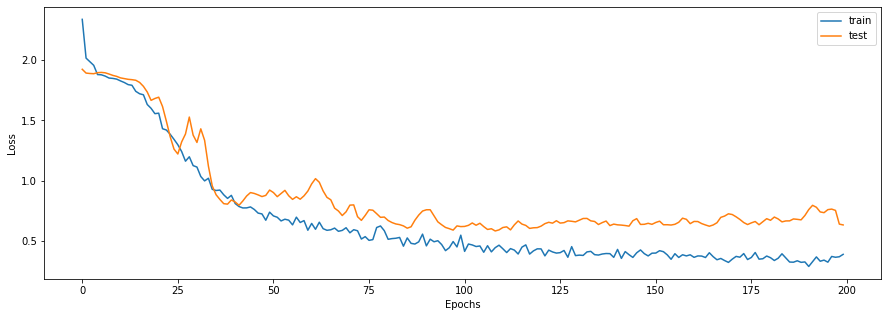

In [ ]:
fig, ax1 = plt.subplots(1, figsize=(15, 5))
ax1.plot(history.history["loss"])
ax1.plot(history.history["val_loss"])
ax1.legend(["train", "test"], loc="upper right")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")

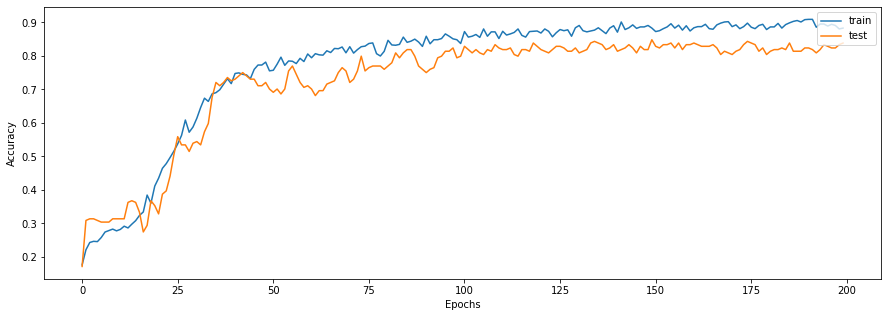

In [ ]:
fig, ax2 = plt.subplots(1, figsize=(15, 5))
ax2.plot(history.history["acc"])
ax2.plot(history.history["val_acc"])
ax2.legend(["train", "test"], loc="upper right")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
plt.show()

**Part-III Paper Implementation:**
Graph convolution networks for Text Classification 

In [ ]:
from google.colab import drive
drive.mount('/content/MyDrive', force_remount=True) 

Mounted at /content/MyDrive


In [ ]:
import sys
sys.path.insert(0,'/content/MyDrive/MyDrive/GTA-1/Proj1/text_gcn-master/text_gcn-master')
import sys
sys.path.append('/content/MyDrive/MyDrive/GTA-1/Proj1/text_gcn-master/text_gcn-master/data')

Dataset: MR-Movie Reviews

In [ ]:
!python /content/MyDrive/MyDrive/GTA-1/Proj1/text_gcn-master/text_gcn-master/remove_words.py mr

shell-init: error retrieving current directory: getcwd: cannot access parent directories: Transport endpoint is not connected
shell-init: error retrieving current directory: getcwd: cannot access parent directories: Transport endpoint is not connected
sh: 0: getcwd() failed: Transport endpoint is not connected
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
{'for', 'below', 'then', 'myself', 'into', "couldn't", "you're", "won't", 'each', 'no', 'when', 'above', 'so', 'll', 'own', "weren't", 'over', 'where', "isn't", "doesn't", 'are', 'does', 'ourselves', 'with', 'again', 't', 'because', 'but', "aren't", 'during', 'can', 'wasn', 'too', 'yours', 've', 'as', 'until', 'will', 'mightn', 'wouldn', 'this', 'had', "wasn't", 'me', 'down', 'am', 'few', 'they', 'more', 'we', 'such', 'here', "haven't", 'has', 'those', 'theirs', "didn't", "that'll", 'at', "hasn't", 'and', 'd', 'yourselves', 'don', 'not', 'nor', 'she', 'both', "sh

In [ ]:
!python /content/MyDrive/MyDrive/GTA-1/Proj1/text_gcn-master/text_gcn-master/build_graph.py mr

shell-init: error retrieving current directory: getcwd: cannot access parent directories: Transport endpoint is not connected
shell-init: error retrieving current directory: getcwd: cannot access parent directories: Transport endpoint is not connected
sh: 0: getcwd() failed: Transport endpoint is not connected
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 15

In [ ]:
!pwd


/content


In [ ]:
import tensorflow as tf
print(tf.__version__)

2.8.0


In [ ]:
!pip install tensorflow==1.15.5

     |████████████████████████████████| 110.5 MB 2.0 kB/s 
     |████████████████████████████████| 2.9 MB 52.9 MB/s 
     |████████████████████████████████| 3.8 MB 59.9 MB/s 
     |████████████████████████████████| 503 kB 86.0 MB/s 
     |████████████████████████████████| 20.1 MB 949 kB/s 
     |████████████████████████████████| 50 kB 8.4 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=a22d61c9f3ab55825c8e361572ab29ab65a57a0d92f582537da2c2fc70bc0bff
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.5
    Uninstalling numpy-1.21.5:
      Successfully uninstalled numpy-1.21.5
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tens

In [ ]:
!python /content/MyDrive/MyDrive/GTA-1/Proj1/text_gcn-master/text_gcn-master/train.py mr


(6398, 300) (6398, 2) (3554, 300) (3554, 2) (25872, 300) (25872, 2)
29426
  (0, 8355)	2.786757278898096
  (0, 10272)	5.808705394582979
  (0, 10380)	8.175829008714597
  (0, 10383)	0.5465010749888104
  (0, 12175)	7.482681828154651
  (0, 14382)	2.2735062248102036
  (0, 15886)	4.174574869558508
  (0, 20068)	5.84045409289756
  (0, 21168)	1.6673331910012603
  (0, 22820)	3.419369375180279
  (0, 23209)	5.777933735916226
  (0, 23924)	0.8349934545913218
  (0, 24697)	5.748080772766545
  (0, 25158)	2.483219834656521
  (0, 25351)	4.369166518944277
  (1, 11144)	2.717662941224664
  (1, 11299)	1.3528114362447363
  (1, 11300)	6.138947081453557
  (1, 12423)	5.040334792785447
  (1, 14811)	5.304149383830585
  (1, 15048)	9.274441297382706
  (1, 15550)	7.328531148327393
  (1, 15840)	9.274441297382706
  (1, 16686)	2.730529451817914
  (1, 18022)	5.131306570991174
  :	:
  (29422, 25671)	1.8885902192574975
  (29423, 11299)	0.6764057181223682
  (29423, 13773)	1.9258537664551136
  (29423, 15148)	3.94172250411733

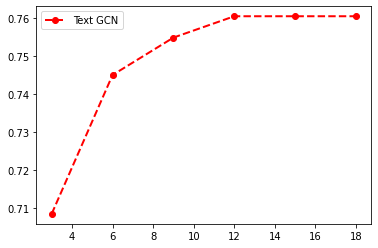

In [ ]:
import matplotlib.pyplot as plt
# matplotlib inline

f = plt.figure()
plt.errorbar(
    [3,6,9,12,15,18],  # X
    [0.70845,0.74507,0.75493,0.76056 ,0.76056,0.76056], # Y
    
    label="Text GCN-MR",
    fmt="ro--", # format line like for plot()
    linewidth=2	# width of plot line
    )


plt.legend() #Show legend
plt.show()

# f.savefig("results/window_R8.pdf", bbox_inches='tight')

**Using dataset ohsumed**

This dataset has 20000 documents from medline dataset and 5 categories like cardio-vascular disease, etc.

In [ ]:
!python /content/MyDrive/MyDrive/GTA-1/Proj1/text_gcn-master/text_gcn-master/remove_words.py ohsumed

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
{'that', 'too', 'than', 'or', "weren't", 'i', 'where', 'himself', 'be', 'up', "won't", 'about', 'him', 'hadn', 'each', 'into', 'any', 'shouldn', 'was', 'your', 'hasn', 'down', 'isn', 'there', 'weren', 'most', 'won', 'what', 'd', 'ain', 'no', 'again', 'my', 'on', "wouldn't", 'it', 's', 'and', 'then', 'same', 'who', 'couldn', "hasn't", 'don', 'the', 'other', 'these', "shan't", "you've", 'before', 'our', 'ourselves', 'itself', 'ma', "don't", 'his', 'doesn', "it's", 'doing', "haven't", 'below', 'were', 'she', "you'd", 'both', 'own', "hadn't", 'whom', 'by', 'am', 'over', 'above', 'm', 'mustn', 'while', 'during', 'didn', 'you', "doesn't", 'an', 'but', 'now', 'this', 'he', 'should', 'does', 'until', 'out', 'yours', 'which', 'more', 'how', "mustn't", 'do', "needn't", 't', 'off', 'had', 'only', "she's", 'here', 've', 'further', 'themselves', 'why', 'such', 'very', 'of', 'will', 'at', '

In [ ]:
!python /content/MyDrive/MyDrive/GTA-1/Proj1/text_gcn-master/text_gcn-master/build_graph.py ohsumed

[4043, 4044, 4045, 4046, 4047, 4048, 4049, 4050, 4051, 4052, 4053, 4054, 4055, 4056, 4057, 4058, 4059, 4060, 4061, 4062, 4063, 4064, 4065, 4066, 4067, 4068, 4069, 4070, 4071, 4072, 4073, 4074, 4075, 4076, 4077, 4078, 4079, 4080, 4081, 4082, 4083, 4084, 4085, 4086, 4087, 4088, 4089, 4090, 4091, 4092, 4093, 4094, 4095, 4096, 4097, 4098, 4099, 4100, 4101, 4102, 4103, 4104, 4105, 4106, 4107, 4108, 4109, 4110, 4111, 4112, 4113, 4114, 4115, 4116, 4117, 4118, 4119, 4120, 4121, 4122, 4123, 4124, 4125, 4126, 4127, 4128, 4129, 4130, 4131, 4132, 4133, 4134, 4135, 4136, 4137, 4138, 4139, 4140, 4141, 4142, 4143, 4144, 4145, 4146, 4147, 4148, 4149, 4150, 4151, 4152, 4153, 4154, 4155, 4156, 4157, 4158, 4159, 4160, 4161, 4162, 4163, 4164, 4165, 4166, 4167, 4168, 4169, 4170, 4171, 4172, 4173, 4174, 4175, 4176, 4177, 4178, 4179, 4180, 4181, 4182, 4183, 4184, 4185, 4186, 4187, 4188, 4189, 4190, 4191, 4192, 4193, 4194, 4195, 4196, 4197, 4198, 4199, 4200, 4201, 4202, 4203, 4204, 4205, 4206, 4207, 4208, 420

In [ ]:
!python /content/MyDrive/MyDrive/GTA-1/Proj1/text_gcn-master/text_gcn-master/train.py ohsumed


(3022, 300) (3022, 23) (4043, 300) (4043, 23) (17514, 300) (17514, 23)
21557
  (0, 3424)	1.5504043808499073
  (0, 3475)	2.2628447643445315
  (0, 3491)	9.210340371976184
  (0, 3494)	7.117475809964206
  (0, 3629)	7.299797366758161
  (0, 4023)	4.53978742672524
  (0, 4090)	5.220355825078324
  (0, 4229)	5.080593882703166
  (0, 4364)	4.041700828736679
  (0, 4458)	5.613398413187932
  (0, 4605)	5.855642135875561
  (0, 4617)	10.07606853656874
  (0, 4664)	2.739624546700805
  (0, 4818)	4.7661005528007285
  (0, 4922)	4.072953372240783
  (0, 4993)	11.656064275037954
  (0, 5133)	2.049620375538059
  (0, 5193)	2.95339790972743
  (0, 5247)	5.220355825078324
  (0, 5257)	7.299797366758161
  (0, 5658)	5.03803426828437
  (0, 5700)	1.6284635361724487
  (0, 5785)	3.29246418152569
  (0, 5821)	5.195663212487953
  (0, 5991)	5.69035945432406
  :	:
  (21556, 14027)	5.91350300563827
  (21556, 14157)	7.935185713165914
  (21556, 14423)	3.9394219796162604
  (21556, 14457)	5.818192825833945
  (21556, 14474)	20.889975

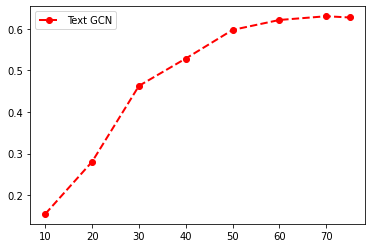

In [ ]:
import matplotlib.pyplot as plt
# matplotlib inline

f = plt.figure()
plt.errorbar(
    [10,20,30,40,50,60,70,75],  # X
    [0.15522,0.28060,0.46269,0.52836,0.59701,0.62090 ,0.62985,0.62687], # Y
    
    label="Text GCN-ohsumed dataset",
    fmt="ro--", # format line like for plot()
    linewidth=2	# width of plot line
    )


plt.legend() #Show legend
plt.show()

# f.savefig("results/window_R8.pdf", bbox_inches='tight')

TSNE plot for the model trained on ohsumed dataset

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


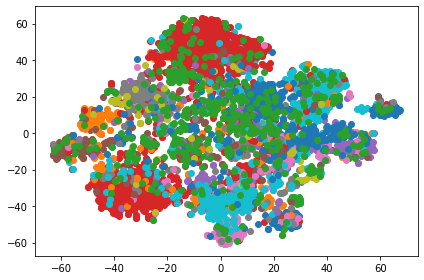

In [ ]:
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
import numpy as np


f = open('/content/MyDrive/MyDrive/GTA-1/Proj1/text_gcn-master/text_gcn-master/data/ohsumed_shuffle.txt', 'r')
lines = f.readlines()
f.close()

f = open('/content/MyDrive/MyDrive/GTA-1/Proj1/text_gcn-master/text_gcn-master/data/ohsumed_doc_vectors.txt', 'r')
embedding_lines = f.readlines()
f.close()

target_names = set()
labels = []
docs = []
for i in range(len(lines)):
    line = lines[i].strip()
    temp = line.split('\t')
    if temp[1].find('test') != -1:
        labels.append(temp[2])
        emb_str = embedding_lines[i].strip().split()
        values_str_list = emb_str[1:]
        values = [float(x) for x in values_str_list]
        docs.append(values)
        target_names.add(temp[2])

target_names = list(target_names)

label = np.array(labels)

fea = TSNE(n_components=2).fit_transform(docs)
pdf = PdfPages('ohsumed_gcn_doc_test_2nd_layer.pdf')
cls = np.unique(label)

# cls=range(10)
fea_num = [fea[label == i] for i in cls]
for i, f in enumerate(fea_num):
    if cls[i] in range(10):
        plt.scatter(f[:, 0], f[:, 1], label=cls[i], marker='+')
    else:
        plt.scatter(f[:, 0], f[:, 1], label=cls[i])
# plt.legend(ncol=2,  )
# plt.legend(ncol=5,loc='upper center',bbox_to_anchor=(0.48, -0.08),fontsize=11)
# plt.ylim([-20,35])
# plt.title(md_file)
plt.tight_layout()
pdf.savefig()
plt.show()
pdf.close()